# Agenda-based Search

#### Author: Kaviraj Gosaye - 220575371

#### Description: Build an AI route finder using an agenda-based search mechanism for the London Tube Underground
#### Algorithms Implemented:
- Breadth-First Search (BFS)
- Depth-First Search (DFS)
- Uniform Cost Search (UCS)
- Best-First Search (BFS) (Heuristic Search)

## 0. Imports

In [1]:
# all imports
import pandas as pd
from collections import defaultdict
import itertools
import networkx as nx
import matplotlib.pyplot as plt

import math
import hashlib
import string
import random
import numpy as np

## 1. Reading the CSV data

In [2]:
# code snippet provided from undirected_map.py

df = pd.read_csv('tubedata.csv', header=None)

# added print to view the records
print(df.head())
 
station_dict = defaultdict(list)
zone_dict = defaultdict(set)

# get data row by row
for index, row in df.iterrows():
  
  start_station = row[0]
  end_station = row[1]
  act_cost = int(row[3])

  zone1 = row[4]
  zone2 = row[5]

  # station dictionary of child station tuples (child_name, cost from parent to the child)
  # {"Mile End": [("Stepney Green", 2), ("Wembley", 1)]}
  station_list = station_dict[start_station]
  station_list.append((end_station, act_cost))

  # the following two lines add the other direction of the tube "step"
  station_list = station_dict[end_station]
  station_list.append((start_station, act_cost))
  
  # we add the main zone
  zone_dict[start_station].add(zone1)
  # we add the secondary zone
  if zone2 != "0":
    zone_dict[start_station].add(zone2)
    # if the secondary zone is not 0 it's the main zone for the ending station
    zone_dict[end_station].add(zone2)
  else:
    # otherwise the main zone for the ending station is the same as for the starting station
    zone_dict[end_station].add(zone1)

                     0                 1         2  3  4  5
0  Harrow & Wealdstone            Kenton  Bakerloo  3  5  0
1               Kenton      South Kenton  Bakerloo  2  4  0
2         South Kenton     North Wembley  Bakerloo  2  4  0
3        North Wembley   Wembley Central  Bakerloo  2  4  0
4      Wembley Central  Stonebridge Park  Bakerloo  3  4  0


## 2. State Representation

To represent the state, a dictionary has been used. The dictionary will have current node, parent node, cost from current to parent node as keys. This representation allows tracking of the nodes for the path of the solution as well as the cost of the paths for that solution.

Example of a state: {'Harrow & Wealdstone': {'Kenton': {'weight': 3}}}

In [3]:
# state representation
stations = dict()
for key, value in station_dict.items():
  temp_dict = dict()
  for x in value:
    # adding weight to the dictionary
    temp_dict[x[0]] = {"weight": x[1]}
  stations[key] = temp_dict

In [4]:
# printing the first station
# to show how it is represented
out = dict(itertools.islice(stations.items(), 1))
print(out)

{'Harrow & Wealdstone': {'Kenton': {'weight': 3}}}


## 3. Visualizing Graph

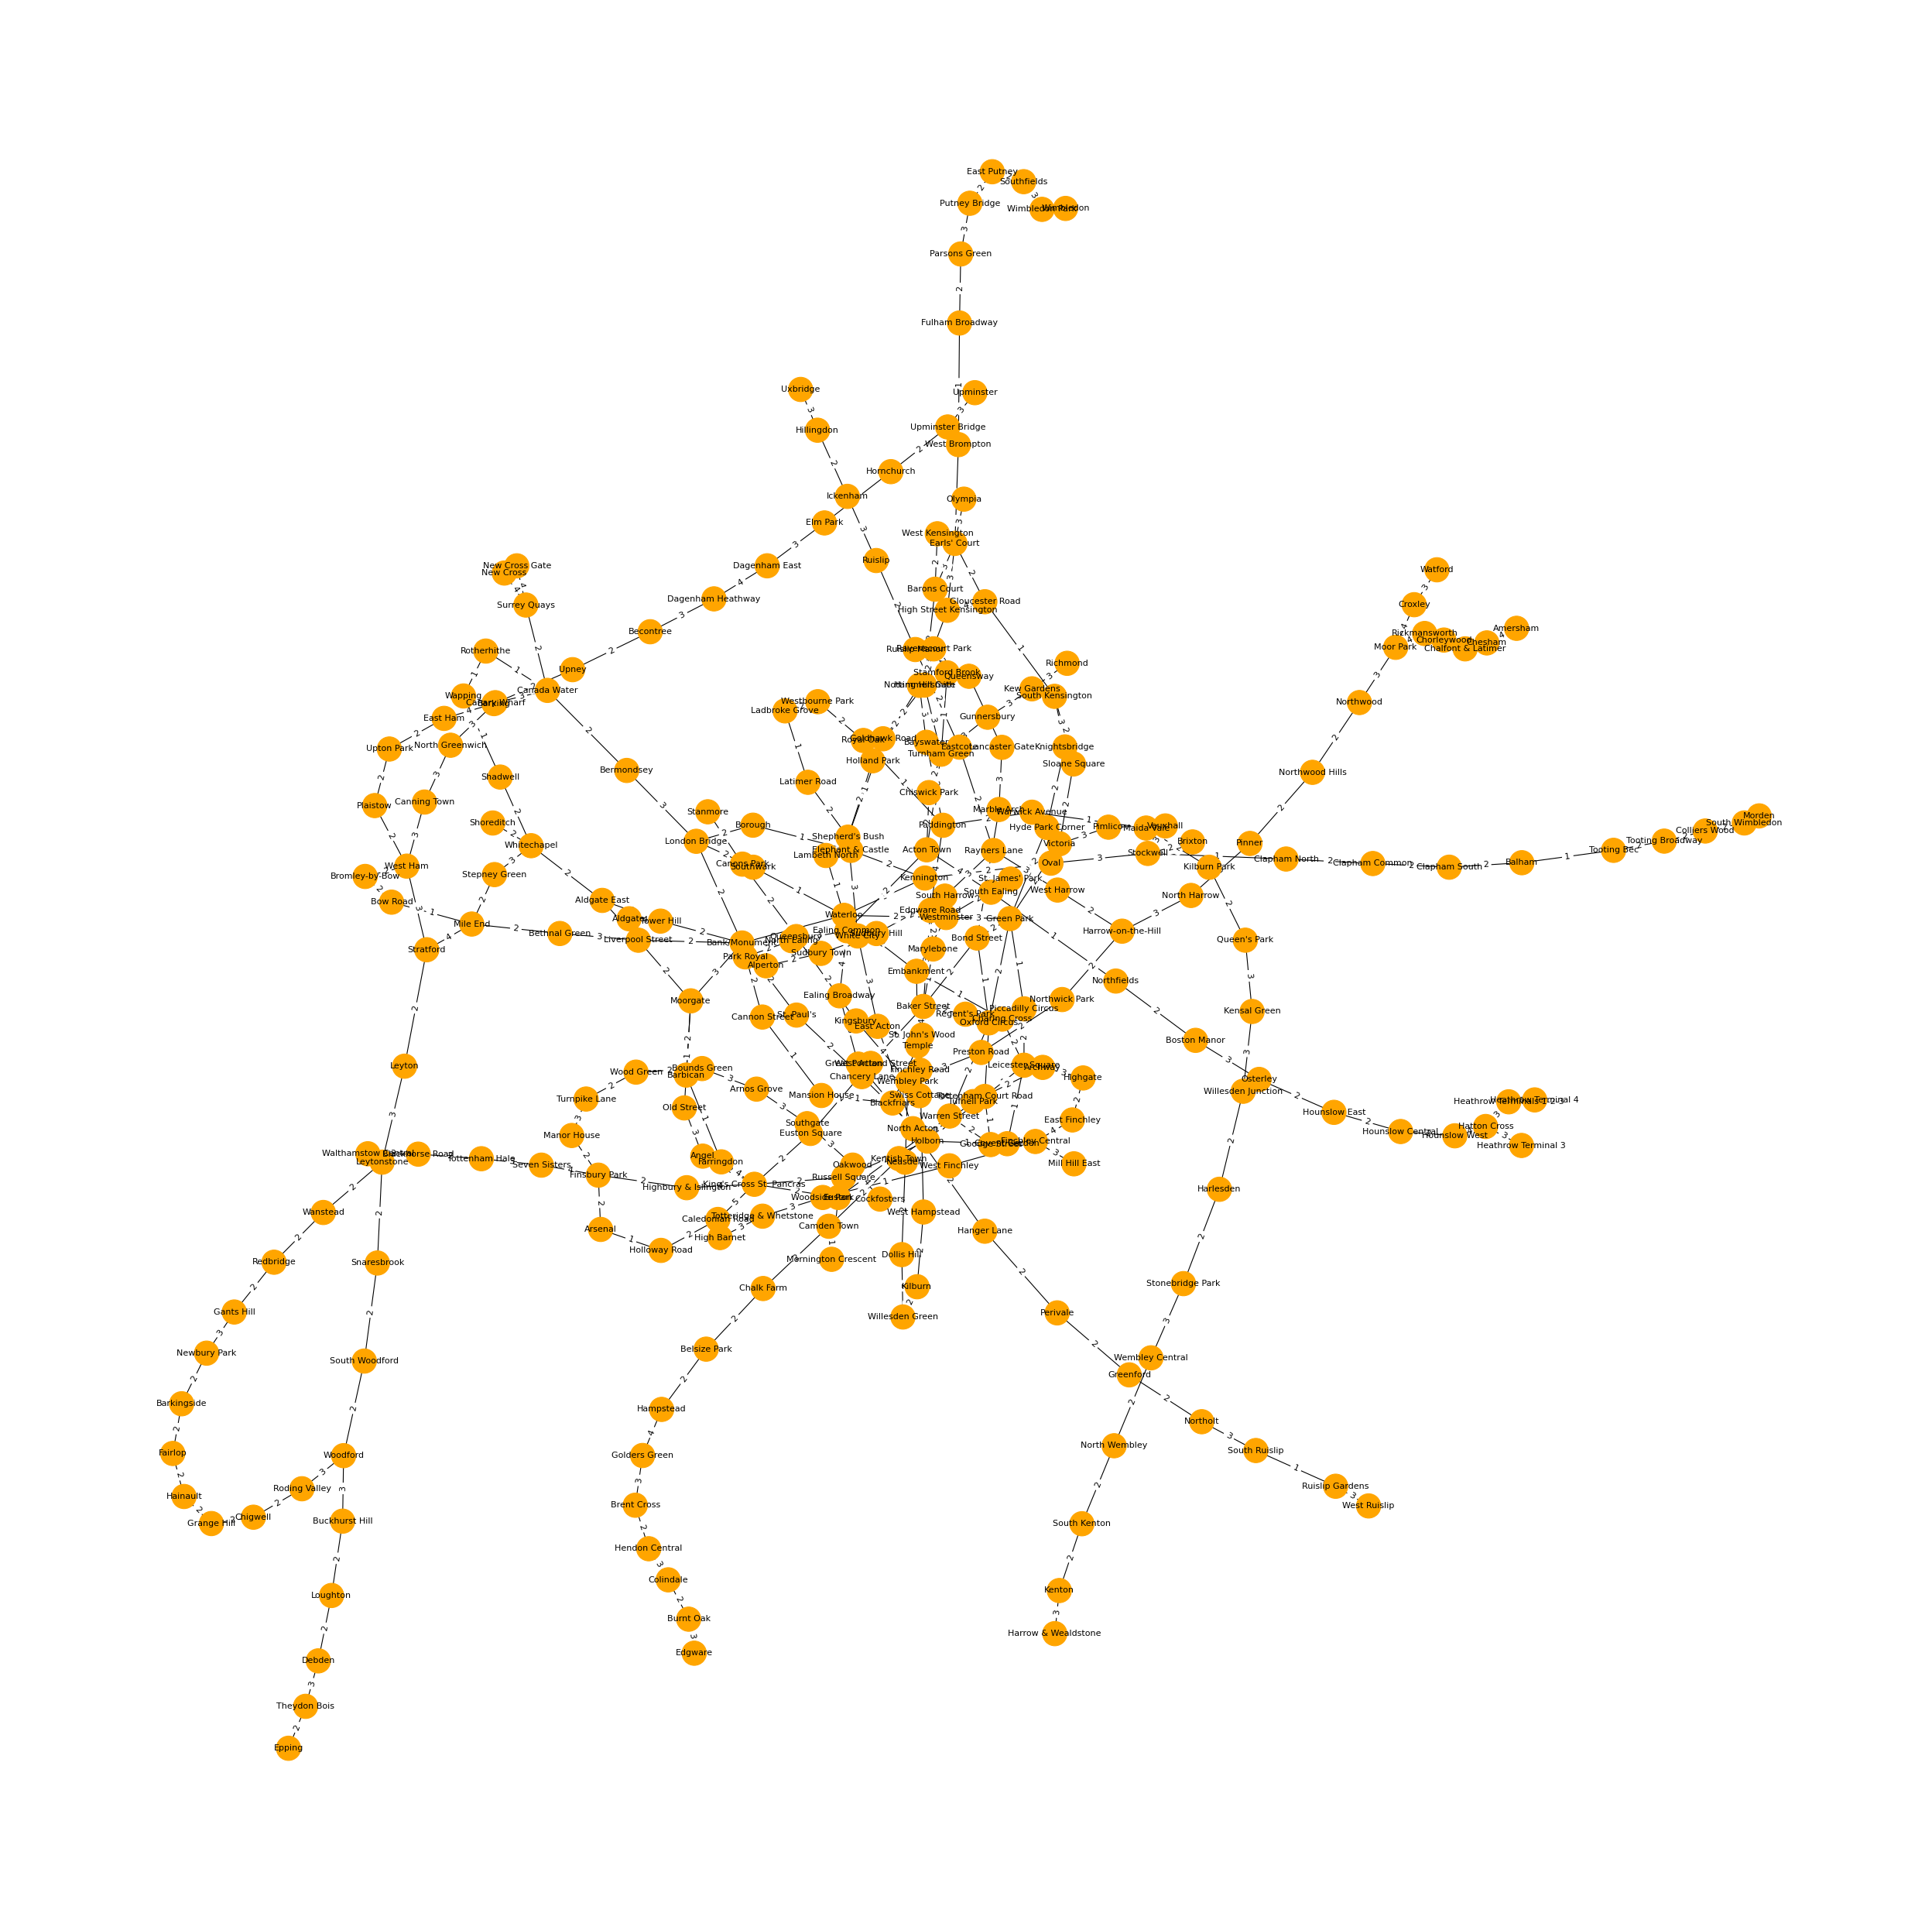

In [5]:
# function to visualize graph
def show_weighted_graph(networkx_graph, node_size, font_size, fig_size):
    plt.figure(num=None,figsize=fig_size, dpi=80)
    plt.axis("off")
    nodes_position = nx.spring_layout(networkx_graph)
    edge_labels = nx.get_edge_attributes(networkx_graph, "weight")
    nx.draw_networkx_nodes(networkx_graph, nodes_position, node_size=node_size, node_color = ["orange"]*networkx_graph.number_of_nodes())
    nx.draw_networkx_edges(networkx_graph, nodes_position)
    nx.draw_networkx_labels(networkx_graph, nodes_position, font_size=font_size, font_family="sans-serif")
    nx.draw_networkx_edge_labels(networkx_graph, nodes_position, edge_labels=edge_labels)
    plt.axis("off")
    plt.show()

graph = nx.Graph(stations)
show_weighted_graph(graph, 800, 10, (40, 40))

## 4. Depth First Search (DFS)

In [6]:
def construct_path_from_root(node, root):
    path_from_root = [node['label']]
    cost = 0
    while node['parent']:
        cost += node['cost']
        node = node['parent']
        path_from_root = [node['label']] + path_from_root
    print("Cost in Average time: ", cost)
    return path_from_root

In [7]:
def my_depth_first_graph_search(nxobject, initial, goal, compute_exploration_cost=False, reverse=False):
    frontier = [{'label':initial, 'parent':None, 'Cost':0}]
    explored = {initial}
    number_of_explored_nodes = 0

    while frontier:
        node = frontier.pop()
        number_of_explored_nodes += 1
        if node['label']==goal:
            if compute_exploration_cost:
                print('number of explorations = {}'.format(number_of_explored_nodes))
            return node

        neighbours = reversed(list(nxobject.neighbors(node['label']))) if reverse else nxobject.neighbors(node['label'])

        for child_label in neighbours:
            if child_label not in explored:
                child = {'label':child_label, 'parent':node, 'cost':nxobject.get_edge_data(node["label"], child_label)["weight"]}
                frontier.append(child)
                explored.add(child_label)
    return None

In [8]:
solution = my_depth_first_graph_search(graph, 'Euston', 'Victoria', True)
construct_path_from_root(solution, 'Euston')

number of explorations = 136
Cost in Average time:  15


['Euston',
 'Warren Street',
 'Goodge Street',
 'Tottenham Court Road',
 'Leicester Square',
 'Charing Cross',
 'Embankment',
 'Westminster',
 'Green Park',
 'Victoria']

## 5. Breadth First Search (BFS)

In [9]:
def my_breadth_first_graph_search(nxobject, initial, goal, compute_exploration_cost=False, reverse=False):

    if initial == goal:
        return None

    number_of_explored_nodes = 0
    frontier = [{'label':initial, 'parent':None, 'cost':0}]
    explored = {initial}

    while frontier:
        node = frontier.pop()
        number_of_explored_nodes += 1
        # goal check
        if node['label']==goal:
            if compute_exploration_cost:
                print('number of explorations = {}'.format(number_of_explored_nodes))
            return node

        neighbours = reversed(list(nxobject.neighbors(node['label']))) if reverse else nxobject.neighbors(node['label'])

        for child_label in neighbours:
            if child_label not in explored:
                child = {'label':child_label, 'parent':node, 'cost': nxobject.get_edge_data(node["label"], child_label)["weight"]}
                frontier = [child] + frontier
                explored.add(child_label)
    return None

In [10]:
solution = my_breadth_first_graph_search(graph, 'Euston', 'Victoria', True)
construct_path_from_root(solution, 'Euston')

number of explorations = 40
Cost in Average time:  7


['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']

## 6. Uniform Cost Search (UCS)

In [11]:
def my_uniform_cost_search(nxobject, initial, goal, compute_exploration_cost=False, reverse=False):
    number_of_explored_nodes = 0 
    frontier = [{'label':initial, 'parent':None, "cost":0}]  
    explored = {initial}

    while frontier:
        node = frontier.pop()
        number_of_explored_nodes += 1
        if node['label'] == goal:
            if compute_exploration_cost == True:
                print('number of explorations = {}'.format(number_of_explored_nodes))
            return node
    
        neighbors = reversed(list(nxobject.neighbors(node['label']))) if reverse else list(nxobject.neighbors(node['label']))
        for child_label in neighbors:
            if child_label not in explored:
                child = {'label':child_label, 'parent': node, 'cost':nxobject.get_edge_data(node['label'], child_label)['weight']}
                frontier =  [child] + frontier
                frontier = sorted(frontier, key=lambda x:x['cost'], reverse=True)
                explored.add(child_label)
    return None

In [12]:
solution = my_uniform_cost_search(graph, 'Euston', 'Victoria', True)
construct_path_from_root(solution, 'Euston')

number of explorations = 30
Cost in Average time:  7


['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']

## 7. Comparison of DFS, BFS and UCS

In [13]:
routes = [('Canada Water', 'Stratford'), ('New Cross Gate', 'Stepney Green'), ('Ealing Broadway', 'South Kensington'), ('Baker Street', 'Wembley Park')]

for start, end in routes:
    print('Start:', start, 'End:', end, '\n')
    
    print('DFS')
    dfs_solution = my_depth_first_graph_search(graph, start, end, True)
    dfs_path = construct_path_from_root(dfs_solution, start)
    print(f'Path: {dfs_path}')
    print('\n')

    print('BFS')
    bfs_solution = my_breadth_first_graph_search(graph, start, end, True)
    bfs_path = construct_path_from_root(bfs_solution, start)
    print(f'Path: {bfs_path}')
    print('\n')
    
    print('UCS')
    ucs_solution = my_uniform_cost_search(graph, start, end, True)
    ucs_path = construct_path_from_root(ucs_solution, start)
    print(f'Path: {ucs_path}')
    
    print(f"\n{'-'*50} \n")

Start: Canada Water End: Stratford 

DFS
number of explorations = 246
Cost in Average time:  15
Path: ['Canada Water', 'Canary Wharf', 'North Greenwich', 'Canning Town', 'West Ham', 'Stratford']


BFS
number of explorations = 38
Cost in Average time:  15
Path: ['Canada Water', 'Canary Wharf', 'North Greenwich', 'Canning Town', 'West Ham', 'Stratford']


UCS
number of explorations = 201
Cost in Average time:  14
Path: ['Canada Water', 'Rotherhithe', 'Wapping', 'Shadwell', 'Whitechapel', 'Stepney Green', 'Mile End', 'Stratford']

-------------------------------------------------- 

Start: New Cross Gate End: Stepney Green 

DFS
number of explorations = 24
Cost in Average time:  25
Path: ['New Cross Gate', 'Surrey Quays', 'Canada Water', 'Canary Wharf', 'North Greenwich', 'Canning Town', 'West Ham', 'Bromley-by-Bow', 'Bow Road', 'Mile End', 'Stepney Green']


BFS
number of explorations = 26
Cost in Average time:  14
Path: ['New Cross Gate', 'Surrey Quays', 'Canada Water', 'Rotherhithe', '

## 8. Comparing Direct and Inverse order of nodes

In [14]:
routes = [('Canada Water', 'Stratford'), ('New Cross Gate', 'Stepney Green'), ('Ealing Broadway', 'South Kensington'), ('Baker Street', 'Wembley Park')]

for start, end in routes:
    print('Start:', start, 'End:', end, '\n')
    
    print('DFS')
    dfs_solution = my_depth_first_graph_search(graph, start, end, True, True)
    dfs_path = construct_path_from_root(dfs_solution, start)
    print(f'Path: {dfs_path}')
    print('\n')

    print('BFS')
    bfs_solution = my_breadth_first_graph_search(graph, start, end, True, True)
    bfs_path = construct_path_from_root(bfs_solution, start)
    print(f'Path: {bfs_path}')
    print('\n')
    
    print('UCS')
    ucs_solution = my_uniform_cost_search(graph, start, end, True, True)
    ucs_path = construct_path_from_root(ucs_solution, start)
    print(f'Path: {ucs_path}')
    
    print(f"\n{'-'*50} \n")

Start: Canada Water End: Stratford 

DFS
number of explorations = 224
Cost in Average time:  20
Path: ['Canada Water', 'Rotherhithe', 'Wapping', 'Shadwell', 'Whitechapel', 'Aldgate East', 'Liverpool Street', 'Bethnal Green', 'Mile End', 'Stratford']


BFS
number of explorations = 27
Cost in Average time:  15
Path: ['Canada Water', 'Canary Wharf', 'North Greenwich', 'Canning Town', 'West Ham', 'Stratford']


UCS
number of explorations = 201
Cost in Average time:  14
Path: ['Canada Water', 'Rotherhithe', 'Wapping', 'Shadwell', 'Whitechapel', 'Stepney Green', 'Mile End', 'Stratford']

-------------------------------------------------- 

Start: New Cross Gate End: Stepney Green 

DFS
number of explorations = 267
Cost in Average time:  14
Path: ['New Cross Gate', 'Surrey Quays', 'Canada Water', 'Rotherhithe', 'Wapping', 'Shadwell', 'Whitechapel', 'Stepney Green']


BFS
number of explorations = 40
Cost in Average time:  14
Path: ['New Cross Gate', 'Surrey Quays', 'Canada Water', 'Rotherhithe

## 9. Extending the Cost Function

The current UCS cost function is improved to include the time to change lines at one station (e.g., 2 minutes)

In [15]:
def ucs_extended(nxobject, initial, goal, compute_exploration_cost=False, reverse=False, data=df):
    number_of_explored_nodes = 0 
    frontier = [{'label':initial, 'parent':None, 'cost':0, 'tube_line':''}]  
    explored = {initial}

    while frontier:
        node = frontier.pop()
        number_of_explored_nodes += 1
        if node['label'] == goal:
            if compute_exploration_cost == True:
                print('number of explorations = {}'.format(number_of_explored_nodes))
            return node
    
        neighbors = reversed(list(nxobject.neighbors(node['label']))) if reverse else list(nxobject.neighbors(node['label']))
        for child_label in neighbors:
            if child_label not in explored:
                # getting the tube line info from the data frame using boolean masking
                tube_line = data[(data.loc[:,0]==node['label'])&(data.loc[:,1]==child_label)][2].values
                
                if 'tube_line' not in node:
                    node['tube_line'] = None
                if (node['tube_line'] not in tube_line) and (len(tube_line) != 0):
                    node['tube_line'] = tube_line[0]
                    # incrementing the cost by 2
                    child = {'label':child_label, 'parent':node, 'cost':nxobject.get_edge_data(node['label'], child_label)['weight'] + 2}
                else:
                    child = {'label':child_label, 'parent':node, 'cost':nxobject.get_edge_data(node['label'], child_label)['weight']}
                    
                frontier =  [child] + frontier
                frontier = sorted(frontier, key=lambda x:x['cost'], reverse=True)
                explored.add(child_label)
    return None

In [16]:
solution_ucs_ext = ucs_extended(graph, 'Euston', 'Victoria', True, data=df)
construct_path_from_root(solution_ucs_ext, 'Euston')

number of explorations = 98
Cost in Average time:  13


['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']

In [17]:
def dfs_extended(nxobject, initial, goal, compute_exploration_cost=False, reverse=False, data=df):
    frontier = [{'label':initial, 'parent':None, 'cost':0, 'tube_line':''}]
    explored = {initial}
    number_of_explored_nodes = 0

    while frontier:
        node = frontier.pop()
        number_of_explored_nodes += 1
        if node['label']==goal:
            if compute_exploration_cost:
                print('number of explorations = {}'.format(number_of_explored_nodes))
            return node

        neighbours = reversed(list(nxobject.neighbors(node['label']))) if reverse else nxobject.neighbors(node['label'])

        for child_label in neighbours:
            if child_label not in explored:
                # getting the tube line info from the data frame using boolean masking
                tube_line = data[(data.loc[:,0]==node['label'])&(data.loc[:,1]==child_label)][2].values
                # print(node)
                # print(node['tube_line'])
                if 'tube_line' not in node:
                    node['tube_line'] = None
                if (node['tube_line'] not in tube_line) and (len(tube_line) != 0):
                    node['tube_line'] = tube_line[0]
                    # incrementing the cost by 2
                    child = {'label':child_label, 'parent':node, 'cost':nxobject.get_edge_data(node['label'], child_label)['weight'] + 2}
                else:
                    child = {'label':child_label, 'parent':node, 'cost':nxobject.get_edge_data(node['label'], child_label)['weight']}
                    
                frontier.append(child)
                explored.add(child_label)
    return None

In [18]:
solution_dfs_ext = dfs_extended(graph, 'Euston', 'Victoria', True, data=df)
construct_path_from_root(solution_dfs_ext, 'Euston')

number of explorations = 136
Cost in Average time:  29


['Euston',
 'Warren Street',
 'Goodge Street',
 'Tottenham Court Road',
 'Leicester Square',
 'Charing Cross',
 'Embankment',
 'Westminster',
 'Green Park',
 'Victoria']

In [19]:
def bfs_extended(nxobject, initial, goal, compute_exploration_cost=False, reverse=False, data=df):

    if initial == goal:
        return None

    number_of_explored_nodes = 0
    frontier = [{'label':initial, 'parent':None, 'cost':0, 'tube_line':''}]
    explored = {initial}

    while frontier:
        node = frontier.pop()
        number_of_explored_nodes += 1
        # goal check
        if node['label']==goal:
            if compute_exploration_cost:
                print('number of explorations = {}'.format(number_of_explored_nodes))
            return node

        neighbours = reversed(list(nxobject.neighbors(node['label']))) if reverse else nxobject.neighbors(node['label'])

        for child_label in neighbours:
            if child_label not in explored:
                 # getting the tube line info from the data frame using boolean masking
                tube_line = data[(data.loc[:,0]==node['label'])&(data.loc[:,1]==child_label)][2].values
                
                if 'tube_line' not in node:
                    node['tube_line'] = None
                if (node['tube_line'] not in tube_line) and (len(tube_line) != 0):
                    node['tube_line'] = tube_line[0]
                    # incrementing the cost by 2
                    child = {'label':child_label, 'parent':node, 'cost':nxobject.get_edge_data(node['label'], child_label)['weight'] + 2}
                else:
                    child = {'label':child_label, 'parent':node, 'cost':nxobject.get_edge_data(node['label'], child_label)['weight']}
                    
                frontier = [child] + frontier
                explored.add(child_label)
    return None

In [20]:
solution_bfs_ext = bfs_extended(graph, 'Euston', 'Victoria', True, data=df)
construct_path_from_root(solution_bfs_ext, 'Euston')

number of explorations = 40
Cost in Average time:  13


['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']

## 10. Heuristic Search

Since the zones of each station was already present in the dataset, it was relatively useful to use that information to calculate the distance between stations. The formula is simply summing all zones in which a station falls under and the mean is calculated. Float division was used to account for decimals. A mapping function was used to convert the ‘a’, ‘b’, ‘c’, ‘d’ to 7, 8, 9 and 10 respectively.

Using this heuristic, least difference between zones for the stations is considered and its nodes explored. This minimizes average time cost to reach end station.

In [21]:
def mapping(zone_dict):
    # mapping each zones with their number
    map = {'1':1, '2':2, '3':3, '4':4, '5':5, '6':6, 'a':7, 'b':8, 'c':9, 'd':10}
    heuristic_dict = dict()
    for name, ids in zone_dict.items():
        temp = list()
        for id in ids:
            h = map[id]
            temp.append(h)
        # computing the average for the heuristic, using float division to allow float values
        h = sum(temp)/len(temp)
        heuristic_dict[name] = h
    return heuristic_dict

In [22]:
# this is the heuristic for best-first search
# the 'straight line distance' is calculated
def heuristic(heuristic_dict, start,  end):   
    start_zone = heuristic_dict[start]
    end_zone = heuristic_dict[end]
    return abs(end_zone-start_zone)

In [23]:
heuristic_dict = mapping(zone_dict)

In [24]:
def best_first_search(nxobject, initial, goal, compute_exploration_cost=False, reverse=False, zones = heuristic_dict):
    number_of_explored_nodes = 0 
    frontier = [{'label':initial, 'parent':None, "cost":0, 'heuristic':0.0}]  
    explored = {initial}

    while frontier:
        node = frontier.pop()
        number_of_explored_nodes += 1
        if node['label'] == goal:
            if compute_exploration_cost == True:
                print('number of explorations = {}'.format(number_of_explored_nodes))
            return node
    
        neighbors = reversed(list(nxobject.neighbors(node['label']))) if reverse else list(nxobject.neighbors(node['label']))
        for child_label in neighbors:
            if child_label not in explored:
                child = {'label':child_label, 'parent': node, 'cost':nxobject.get_edge_data(node['label'], child_label)['weight'], 'heuristic':heuristic(zones, node['label'], child_label)}
                frontier =  [child] + frontier
                frontier = sorted(frontier, key=lambda x:x['heuristic'], reverse=True)
                explored.add(child_label)
    return None

In [25]:
solution_best_fs = best_first_search(graph, 'Euston', 'Victoria', True)
construct_path_from_root(solution_best_fs, 'Euston')

number of explorations = 20
Cost in Average time:  7


['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']